# <center> Guia 3 </center>
Alumno: Brusco Agustín

Docentes: Rodriguez Imazio Paola, Amette Estrada Julian

## Imports Generales
Ejecutar la siguiente celda para poder correr el código del Notebook.

In [1]:
import sys
import os
# Colab Set-Up
if ("google.colab" in sys.modules) and (os.getcwd() == '/content'):
    print(
        "Ejecutando en Google Colab\n"
        "Para correr el notebook se necesita clonar un repositorio con funciones "
        "auxiliares e instalar librerías."
    )
    if input(
        "¿Desea clonar el repositorio e instalar los paquetes necesarios?"
        "[y/n]:"
    ).lower() == "y":
        os.system("git clone https://github.com/agustinbrusco/Sistemas_Complejos.git")
        print(
            "Se clonó https://github.com/agustinbrusco/Sistemas_Complejos.git."
        )
        os.chdir("Sistemas_Complejos/guias/")
        %pip install findiff
        %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

# Imports Generales
from typing import Callable
import numpy as np
from numpy.typing import ArrayLike

import matplotlib.pyplot as plt
# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

from utils import (plot_3d_evolution, plot_colorline)

# Modelo de población
## <center> Ecuación logística </center>

Vamos a partir de un sistema gobernado por la ecuación:

$$\frac{\partial N}{\partial t}(x,t) = \alpha \left( 1 - \frac{1}{C(x,t)}N \right) + \nu \nabla^2 N.$$

Esta ecuación es una versión de la ecuación logística. Podemos interpretarlo como un modelo de población tanto en el espacio como en el tiempo donde $N(x,t)$ es la población que se encuentra en cierta posición en un determinado tiempo, $C(x,t)$ representa el valor de saturación de la población dado los recursos que se encuentran, $\alpha$ es la tasa de creciciento de la población cuando existen infinitos recursos y $\nu$ un parámetro que determina la migración de individuos hacia áreas menos pobladas.

Utilizaremos para este modelo recursos que oscilarán en el espacio y el tiempo, representando el cambio en las estaciones de las zonas más aptas para vivir. Entonces, tendrá la forma funcional:

$$ C(x,t) = c_0 (1 + 0.8 \cos(\omega_1 t) \sin (\omega_2 x)).$$

$\bf a)$ Escriba un método pseudoespectral (con Runge-Kutta de orden 2 midpoint para el tiempo) que integre el sistema presentado anteriormente usando $N = 1024$ puntos de grilla, $dt = 1 \times 10^{-3}$, $\nu = 5 \times 10^{-5}$, $\alpha = 3$, $c_0 = 15$, $t_f = 4 \pi$, $\omega_1 = 2$, $\omega_2 = 1$ y $x \in [0, 2\pi]$. Use como condición inicial una población constante de 10 en todos lados. Grafique como una imagen $N(x,t)$.

$\bf b)$ Aplique la técnica de descomposición ortogonal empírica para separar la solución en componentes temporales y espaciales. Grafique ordenadamente los autovalores e interprete su significado. Grafique para distinto número de modos (1, 2, 3, etc) y relacionelo con los autovalores. ¿Qué criterio puede utilizar para elegir el número de modos?

$\bf c)$ Plantee analíticamente una descomposición de Galerkin en funciones genéricas para esta ecuación. (se recomienda hacerlo con detenimiento)

$\bf e)$ Ahora realice el proceso inverso. Usando el item $\bf b$, escriba un código que tome los primeros $n$ modos que obtiene de POD y escriba un integrador que evolucione estos modos. Use las mismas condiciones que en el item $a$. Para la condición inicial proyecte la utilizada en los modos elegidos. Pruebe para tres $n$ distintos y que uno sea 3.¿Qué conclusiones obtiene?

$\bf f)$ Para $n=3$ varíe el parámetro $\alpha$ y use el integrador obtenido del punto anterior. En este caso no estaremos usando los modos de POD que sabemos que forman parte de la solución. Compare con la integración directa de este caso. ¿Por qué los modos POD de un problema con otros parámetros sigue funcionando en este caso?

$\bf g)$ Repita el punto anterior pero ahora con $\omega_1 = 1$.


$\bf h)$ Escriba un integrador temporal para de 3 modos Fourier para esta ecuación (se recomienda reciclar el anterior). Compare con los resultados de POD que obtuvo en el item $\bf e$.

(opcional: encuentre un régimen nuevo de parámetros para los cuales los 3 modos obtenidos de POD no permiten reflejar la dinámica)

[IMPORTANTE: RESOLVER LOS ITEMS EN CELDAS SEPARADAS, MARCANDO CLARAMENTE EL I]


### a)
Primero tenemos la Ecuación Logistica en Derivadas Parciales en el caso de una dimensión:
$$\frac{\partial N}{\partial t}(x,t) = \alpha \left( 1 - \frac{1}{C(x,t)}N \right) + \nu \frac{\partial^2 N}{\partial x^2}$$
Transformando en Fourier la coordenada espacial $x$ y notando $\hat{N}(k,t)$ a la transformada de Fourier de $N(x,t)$, tenemos:
$$\frac{\partial \hat{N}}{\partial t}(k,t) = \alpha \,\mathcal{F}\left[ 1 - \frac{1}{C(x, t)}\mathcal{F}^{-1}\left[\hat{N}\right]\right] - \nu k^2 \hat{N}$$

Definiendo ahora el lado derecho de la ecuación como $\phi(t, \hat{N})$, tenemos que el método de Runge-Kutta de orden 2 midpoint para el tiempo queda:
$$\hat{N}_{t + \mathrm{d} t} = \hat{N}_{t} + \mathrm{d} t \cdot \phi\left(t + \mathrm{d} t/2, \hat{N}_{t} + \frac{\mathrm{d} t}{2} \cdot \phi\left(t, \hat{N}_{t}\right)\right)$$

In [2]:
def evol(
    n: ArrayLike,
    k: ArrayLike,
    c: ArrayLike,
    alpha: float,
    nu: float,
    dt: float,
) -> ArrayLike:
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    n_hat = np.fft.rfft(n)  # Transformamos al espacio de Fourier
    x_muestras = n.size
    n_hat_inicial = n_hat  # Guardamos el estado inicial
    for ord in [2,1]:  # Bucle para el Runge-Kutta
        D = dt/ord
        recursos_hat = calcular_recursos(n_hat, c)
        n_hat = n_hat_inicial + D*(alpha*recursos_hat - nu*(k**2)*n_hat)  # Integramos en el tiempo
        n_hat[int(x_muestras/3):] = 0  # Dealiasing (eliminemos modos espúreos!)
    n_nuevo = np.fft.irfft(n_hat)  # Vuelva del espacio de Fourier
    return n_nuevo

def calcular_recursos(n_hat: ArrayLike, c: ArrayLike) -> ArrayLike:
    """Calcula: $1 - \frac{1}{C(x, t)}\mathcal{F}^{-1}\left[\hat{N}\right]$ \
usando el método pseudoespectral y devuelve el resultado en el espacio Fourier.
    """
    n = np.fft.irfft(n_hat)
    recursos_hat = np.fft.rfft(1 - n/c)
    return recursos_hat

In [3]:
nx = 1024
dt = 1e-3
tf = 4 * np.pi
L = 2 * np.pi

x_vals = np.linspace(0, L, nx, endpoint=True)  # Coordenada espacial en [0,2*pi]
t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
x_grid, t_grid = np.meshgrid(x_vals, t_vals, indexing="xy")  # Grilla para graficar
nt = t_vals.size
# Números de onda ordenados como en la FFT
k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

In [4]:
# Parámetros del modelo
nu = 5e-5
alpha = 3

def c_func(
    x: ArrayLike,
    t: ArrayLike,
    c0: float,
    w1: float,
    w2: float,
) -> ArrayLike:
    return c0 * (1 + 0.8 * np.cos(w1*t) * np.sin(w2*x))

n = np.empty([nx, nt])  # Array con la velocidad
n[:, 0] =np.full_like(x_vals, 10, dtype=float)  # CI: 10 individuos en todos los puntos

# Evolucionamos en el tiempo
for i, t_i in enumerate(t_vals[:-1]):
    n[:, i+1] = evol(
        n[:, i],
        k_vals,
        c_func(x_vals, t_i, c0=15, w1=2, w2=1),
        alpha,
        nu,
        dt,
    )

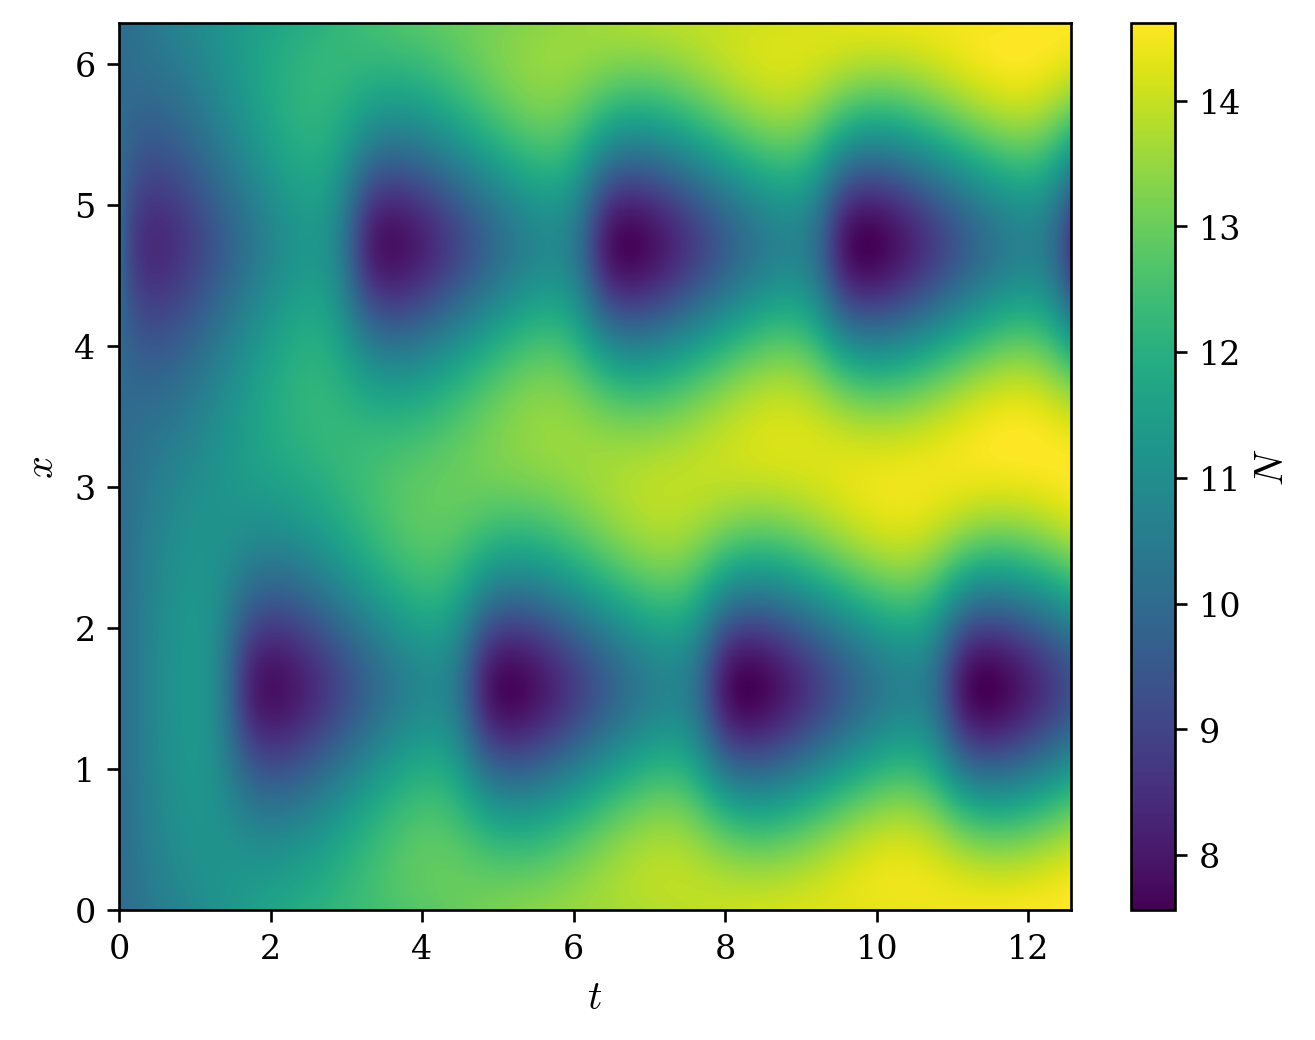

In [5]:
%matplotlib inline
plt.figure()
plt.pcolormesh(t_grid, x_grid, n.T, shading="auto", cmap="viridis")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.colorbar(label="$N$")
plt.show()

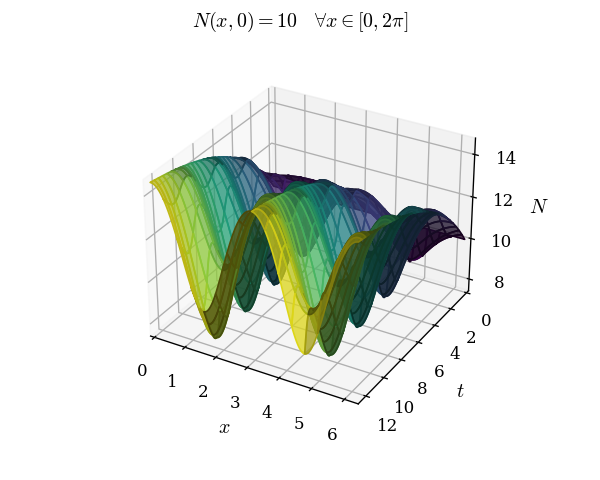

In [6]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, n, cmap_name="viridis", t_sample_size=16, x_sample_size=32)
fig.set_label("Evolución de la Ecuación Logística mediante Método Pseudoespectral")
fig.suptitle(r"$N(x, 0) = 10 \quad \forall x \in [0, 2\pi]$")
ax.set_zlabel("$N$")
plt.show()

In [5]:
plt.close("all")

### b)

In [6]:
autovals, phi = np.linalg.eigh((n / nt) @ (n.T), )
# np.sum(phi**2, axis=1)  # Los vectores phi están normalizados
sorted_args = np.argsort(np.abs(autovals))[::-1]
autovals = autovals[sorted_args]
phi = phi[:, sorted_args]
a = n.T @ phi

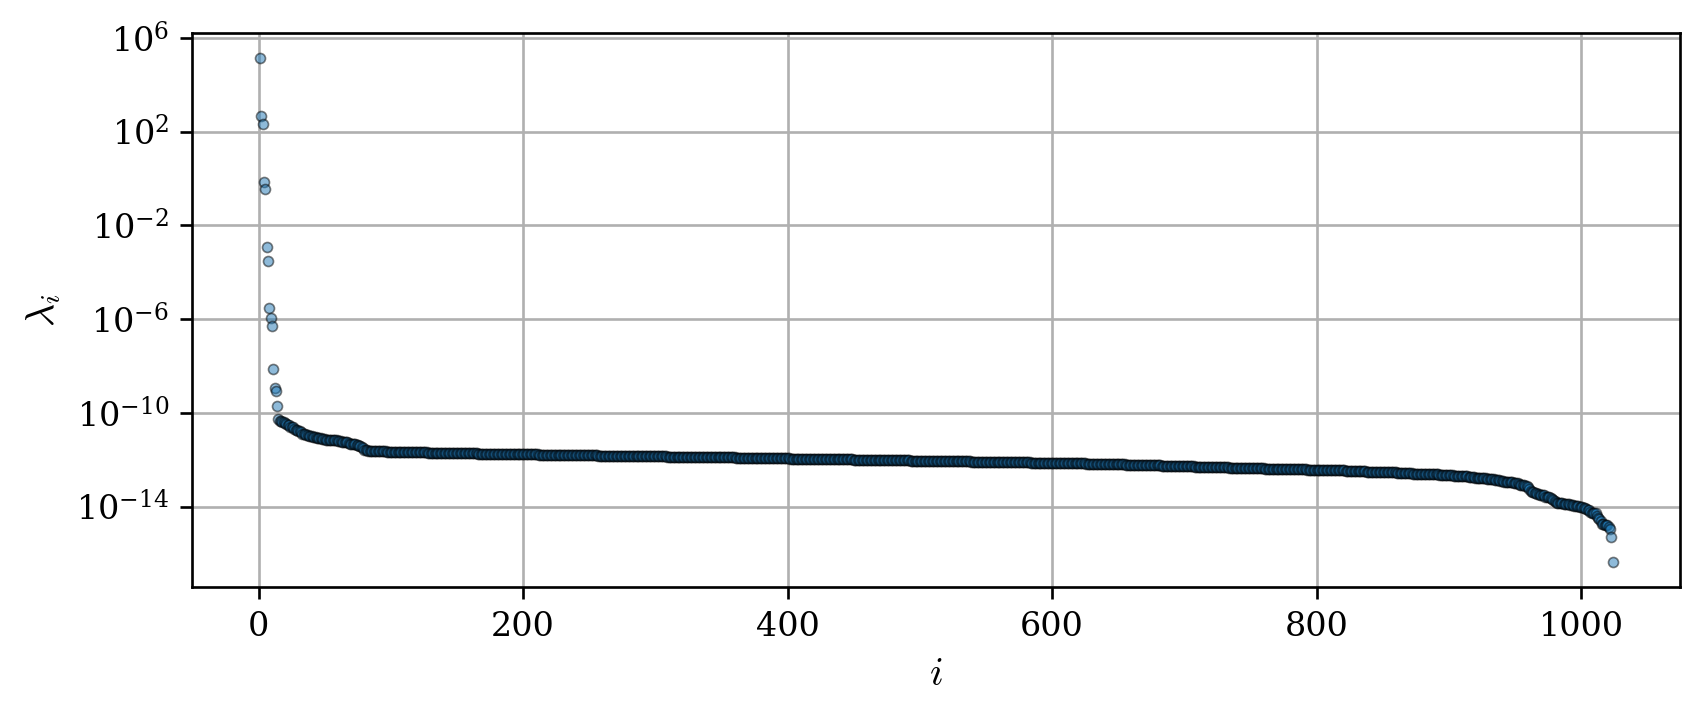

In [56]:
%matplotlib inline
plt.figure(figsize=(8, 3))
plt.plot(np.arange(len(autovals))+1, np.abs(autovals), '.', mec="k", mew=0.5, alpha=0.5)
plt.grid()
plt.yscale("log")
plt.ylabel("$\lambda_i$")
plt.xlabel("$i$")
# plt.xlim(-1, 30)
plt.show()

Observando los valores de $\lambda_i$ ordenados resulta notable que el primer autovalor es ordenes de magnitud más grande que los demás. Esto es: en la evolución del sistema, el modo de mayor autovalor tiene $\sim 10^{15}$ veces más peso que los modos 15 en adelante (cuyos autovalores son del orden de $10^{-10}$)

In [40]:
print(*(autovals.cumsum()/np.abs(autovals).sum()))

0.9949422292656428 0.998469100939324 0.9999921716802759 0.9999974464402844 0.9999999892554053 0.9999999977558248 0.9999999999663779 0.9999999999876508 0.9999999999961541 0.9999999999999156 0.9999999999999706 0.9999999999999792 0.9999999999999856 0.9999999999999871 0.9999999999999876 0.9999999999999871 0.9999999999999867 0.9999999999999869 0.9999999999999867 0.9999999999999865 0.9999999999999867 0.9999999999999865 0.9999999999999862 0.9999999999999865 0.9999999999999862 0.9999999999999865 0.9999999999999867 0.9999999999999869 0.9999999999999871 0.9999999999999869 0.9999999999999867 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.9999999999999869 0.99999999999

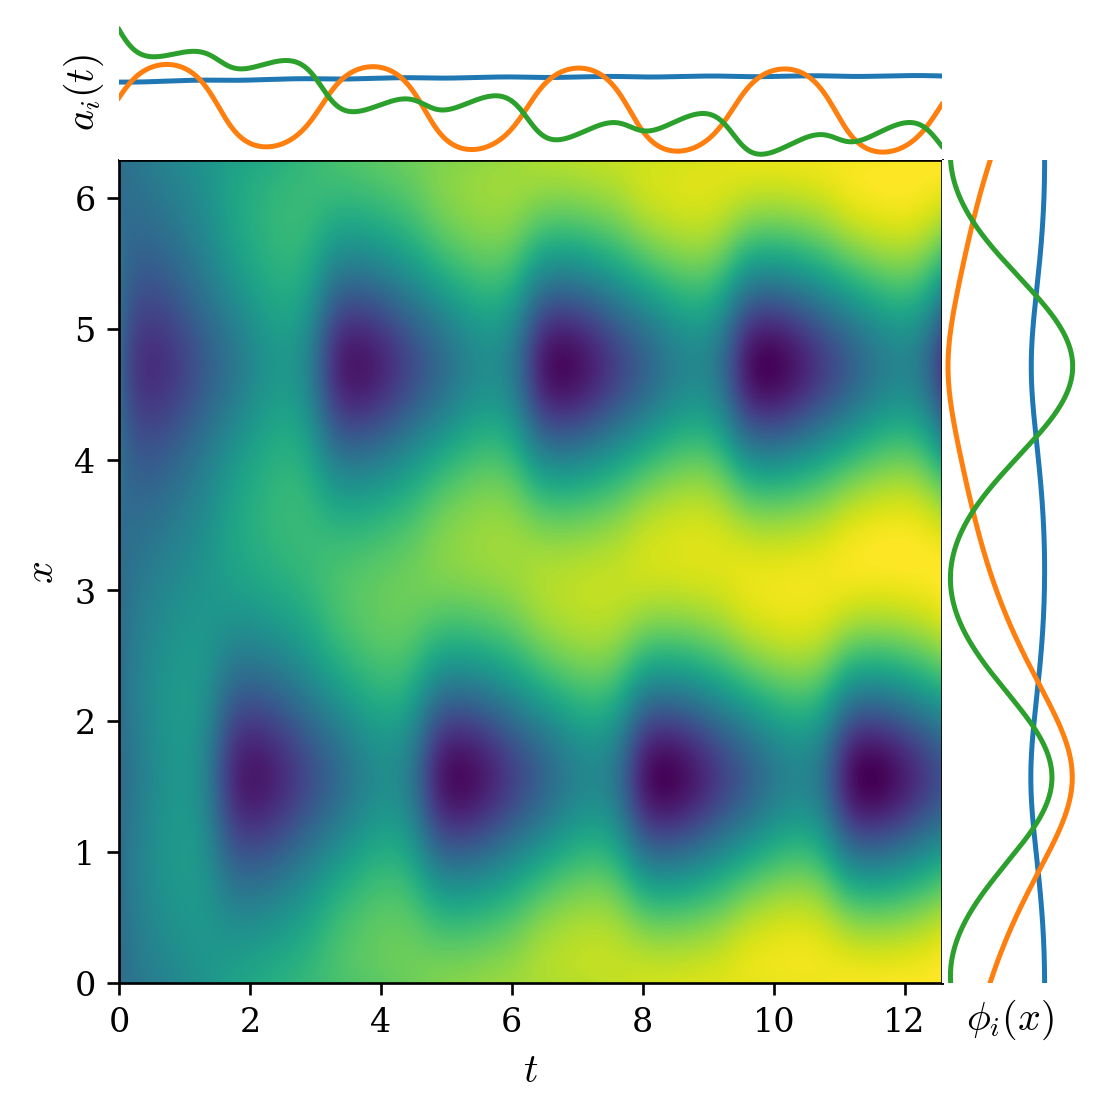

In [57]:
%matplotlib inline
fig = plt.figure(figsize=(5, 5))

# Also adjust the subplot parameters for a square plot.
edge_axis_ratio = 6
gs = fig.add_gridspec(
    2, 2,
    width_ratios=(edge_axis_ratio, 1), height_ratios=(1, edge_axis_ratio),
    left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0
)
# Create the Axes.
ax_center = fig.add_subplot(gs[1, 0])
ax_x = fig.add_subplot(gs[0, 0], sharex=ax_center)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax_center)

    

# Defino los modosa graficar:
i_min = 0
i_max = 2
n_truncado = phi[:, i_min:i_max+1] @ a[:, i_min:i_max+1].T

# Plot central con la imagen de la solución truncada
ax_center.pcolormesh(t_grid, x_grid, n_truncado.T, shading="auto", cmap="viridis")
ax_center.set_xlabel("$t$")
ax_center.set_ylabel("$x$")

# Plots de los bordes con φ_i(x) y a_i(t)
for i in range(i_min, i_max+1):
    # ax_x.scatter(t_vals, a[:, i], cmap="viridis", c=a[:, i], s=1)
    ax_x.plot(t_vals, a[:, i]/autovals[i]**0.5, "-")
    # ax_y.scatter(phi[:, i], x_vals, cmap="viridis", c=phi[:, i], s=1)
    ax_y.plot(phi[:, i], x_vals, "-")

    
if i_max == i_min:
    ax_x.set_ylabel(fr"$a_{i}(t)$")
    ax_y.set_xlabel(fr"$\phi_{i}(x)$")
else:
    ax_x.set_ylabel(r"$a_{i}(t)$")
    ax_y.set_xlabel(r"$\phi_{i}(x)$")
for ax in [ax_x, ax_y]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks and labels
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False,
    )
plt.show()

In [8]:
def signed_colors(vals: ArrayLike) -> ArrayLike:
    extremo = np.max(np.abs(vals)) 
    norm = plt.Normalize(-extremo, extremo)
    return norm(vals)

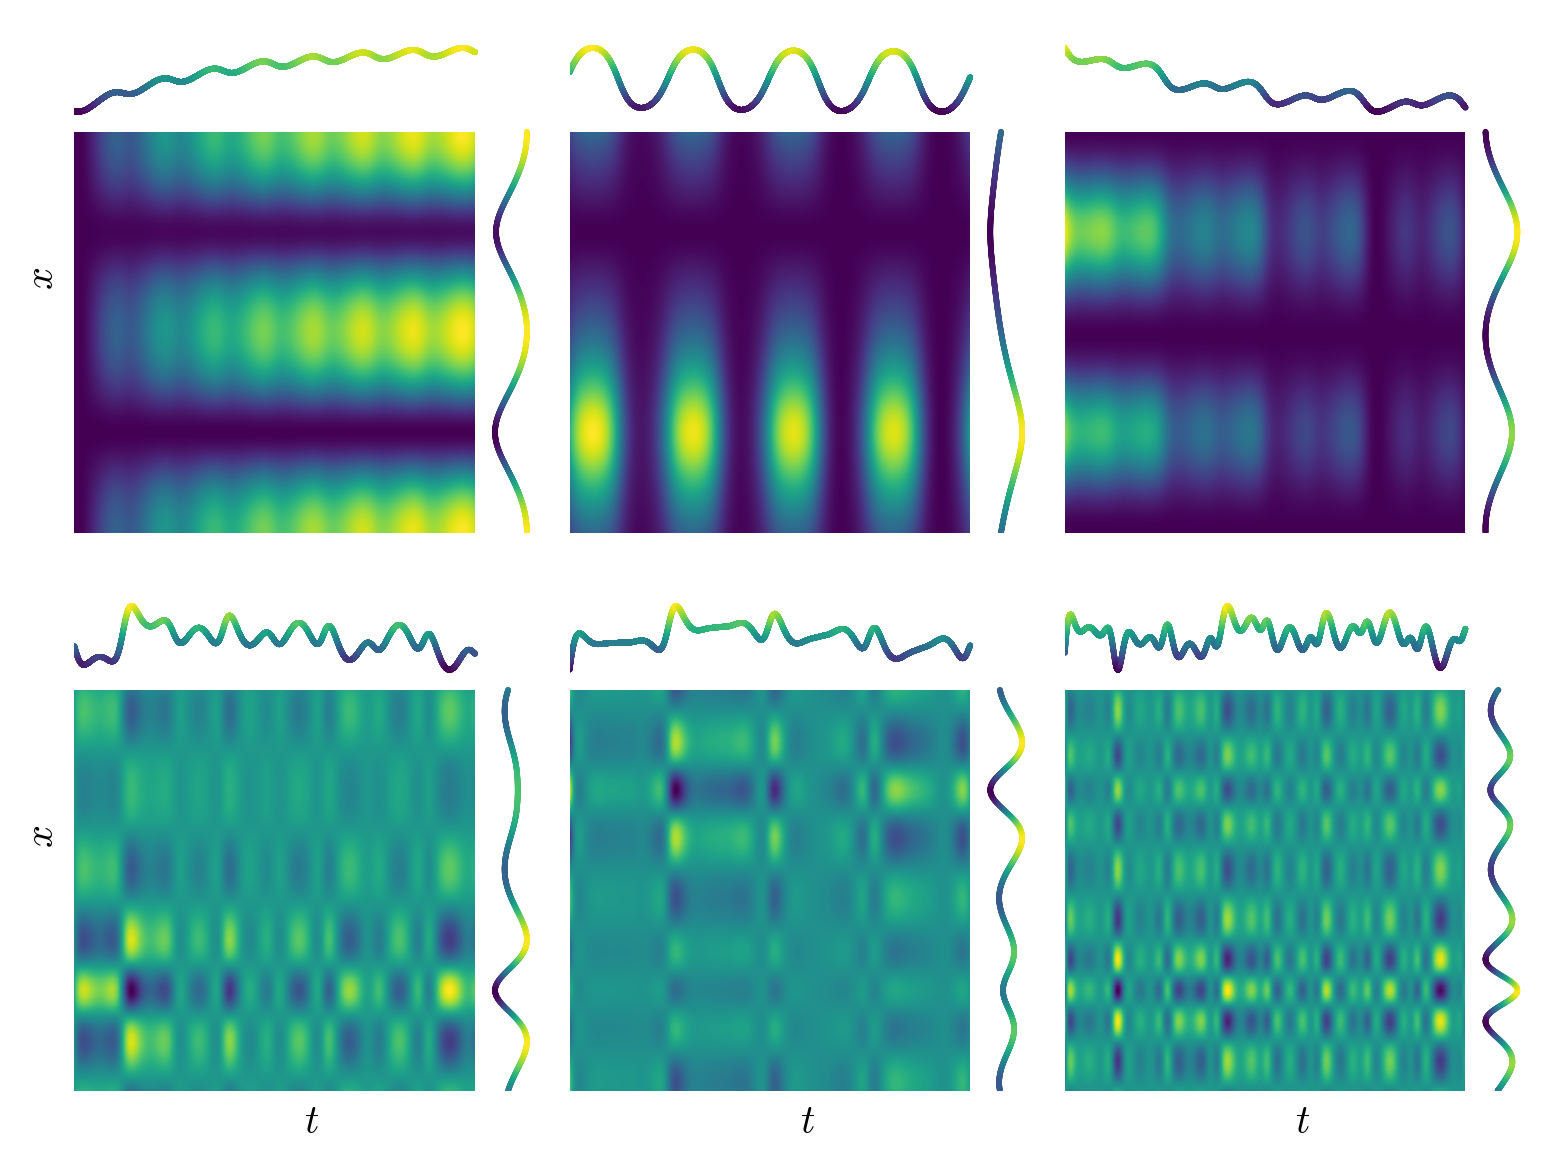

In [28]:
%matplotlib inline
fig, axs = plt.subplots(
    2, 3,
    sharex=True, sharey=True,
    constrained_layout=True, squeeze=False,
)
for i, ax in enumerate(axs.flatten()):
    modo = phi[:, i:i+1] @ a[:, i:i+1].T
    modo_cmap = plt.cm.ScalarMappable(
        norm=plt.Normalize(modo.flatten().min(), modo.flatten().max()),
        cmap="viridis",
    )
    ax.pcolormesh(
        t_grid, x_grid,
        modo_cmap.to_rgba(modo.T),
        shading="auto",
    )
    a_plot = a[:, i]
    a_plot -= a_plot.min()
    a_plot /= a_plot.max()
    a_cmap = plt.cm.ScalarMappable(
        norm=plt.Normalize(a[:, i].min(), a[:, i].max()),
        cmap="viridis",
    )
    ax.scatter(
        t_vals, a_plot + x_vals.max()*1.05,
        s=0.5, c=a_cmap.to_rgba(a[:, i]),
    )
    phi_plot = phi[:, i]
    phi_plot -= phi_plot.min()
    phi_plot /= phi_plot.max()
    phi_cmap = plt.cm.ScalarMappable(
        norm=plt.Normalize(phi[:, i].min(), phi[:, i].max()),
        cmap="viridis",
    )
    ax.scatter(
        phi_plot + t_vals.max()*1.05, x_vals,
        s=0.5, c=phi_cmap.to_rgba(phi[:, i])
    )
    for edge in ["top", "right", "bottom", "left"]:
        ax.spines[edge].set_visible(False)
    ax.set_aspect(t_vals.max() / x_vals.max())
for ax in axs[-1]:
    ax.set_xlabel("$t$")
for ax in axs[:, 0]:
    ax.set_ylabel("$x$")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [52]:
sum(phi[0] * phi[1])

-4.938540895671473e-16

### c)
Para desarrollar Galerkin la ecuación $\frac{\partial N}{\partial t}(x,t) = \alpha \left( 1 - \frac{1}{C(x,t)}N \right) + \nu \nabla^2 N$ procedemos a proponer una descomposición según:
$$N(x, t) = \sum_{i = 0}^\infty a_i(t)\, \phi_i(x)$$
Donde definimos que $\left\{\phi_i(x)\right\}_{i \in \mathbb{N}}$ es una base ortonormal de funciones en $x$ tal que:
$$\int\limits_{-\infty}^{\infty} \phi_j^*(x) \phi_i(x) \omega(x)\, \mathrm{d}x = \delta_{ij}$$

Luego, reemplazando la descomposición de $N$ en la ecuación original:
$$\begin{align*}
    \sum_{i = 0}^\infty \dot{a}_i(t)\, \phi_i(x) = & \alpha \left( 1 - \frac{1}{C(x,t)}\sum_{i=0}^\infty a_i(t)\, \phi_i(x) \right) \\
    & + \nu \sum_{i=0}^\infty a_i(t)\, \frac{\partial^2}{\partial x^2} \phi_i(x) \\
\end{align*}$$
Y multiplicando por $\phi_j^*(x) \omega(x)$ e integrando en todo el dominio espacial tenemos:
$$\begin{align*}
    \dot{a}_j(t) = & \,\alpha\left( \int\limits_{-\infty}^{\infty} \phi_j^*(x) \omega(x)\, \mathrm{d}x - \sum_{i=0}^\infty a_i(t)\, \int\limits_{-\infty}^{\infty} \frac{\phi_j^*(x) \phi_i(x) \omega(x)}{C(x,t)}\, \mathrm{d}x \right) \\
    & + \nu \sum_{i=0}^\infty a_i(t)\, \int\limits_{-\infty}^{\infty} \phi_j^*(x) \frac{\partial^2}{\partial x^2} \phi_i(x) \omega(x)\, \mathrm{d}x \\
\end{align*}$$

Definiendo entonces el vector $A_j = \int\limits_{-\infty}^{\infty} \phi_j^*(x) \omega(x)\, \mathrm{d}x$, la matriz $T_{ij}(t) = \int\limits_{-\infty}^{\infty} \frac{\phi_j^*(x) \phi_i(x) \omega(x)}{C(x,t)}\, \mathrm{d}x$ y la matriz $B_{ij} = \int\limits_{-\infty}^{\infty} \phi_j^*(x) \frac{\partial^2}{\partial x^2} \phi_i(x) \omega(x)\, \mathrm{d}x$, podemos escribir la ecuación de evolución de los coeficientes como:
$$\dot{a}_i(t) = \alpha\left( A_i - \sum_{i=0}^\infty T_{ij}(t)\, a_j(t) \right) + \nu \sum_{i=0}^\infty B_{ij}\, a_j(t)$$
$$\iff \dot{\vec{a}}(t) = \alpha\left( \vec{A} - \mathbb{T}(t)\, \vec{a}(t) \right) + \nu \mathbb{B}\, \vec{a}(t)$$
$$\iff \dot{\vec{a}}(t) = \alpha \vec{A} - \left(\alpha \mathbb{T}(t) - \nu \mathbb{B}\right)\, \vec{a}(t)$$

### e)
Para escribir un integrador a partir de la expresión obtenida necesitamos discretizar en $x$ para calcular $\vec{A}$ y las matrices $\mathbb{T}$ y $\mathbb{B}$.

Al discretizar en $x$ pasamos de tener infinitas funciones $\phi_i(x):\mathbb{R}\to\mathbb{R}$ a tener $n_x$ vectores $\vec{\phi}_i \in \mathbb{R}^{n_x}$. A su vez, la condición de ortonormalidad pasa a ser $\vec{\phi}_j^* \vec{\phi}_i = \delta_{ij}$. Así, las integrales pasan a ser sumas a lo largo de las coordenadas espaciales de manera que se tiene:
$$\begin{align*}
A_j = \vec{\phi}_j^* \cdot \vec{1}\quad & / & \vec{A} = \Phi^* \vec{1} \\
T_{ij} = \vec{\phi}_j^* \cdot \overrightarrow{\frac{\phi_i}{C(t)}}\quad & / & \mathbb{T} = \Phi^* \cdot \mathbb{C}^{-1} \cdot \Phi
\end{align*}$$
